# K-means, BIC, AIC

## Data

In [1]:
import numpy as np
import random
from numpy.random import normal
from collections import namedtuple

Data = namedtuple('Data', 'X y')

random.seed(37)
np.random.seed(37)

def get_data(means, variances, labels, N=1000):
    def get_X(sample_means, sample_variances, N):
        return np.hstack([normal(m, v, N).reshape(-1, 1) for m, v in zip(sample_means, sample_variances)])

    def get_y(label, N):
        return np.full(N, label, dtype=np.int)

    X = np.vstack([get_X(m, v, N) for m, v in zip(means, variances)])
    y = np.hstack([get_y(label, N) for label in labels])

    return Data(X, y)

# training
means = [
    [5.0, 5.0],
    [99.0, 99.0],
    [15.0, 20.0]
]
variances = [
    [1.0, 1.0],
    [1.0, 1.0],
    [1.0, 1.0]
]
labels = range(len(means))

X, y = get_data(means=means, variances=variances, labels=labels)

print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (3000, 2), y shape (3000,)


## BIC, AIC and more

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn

def get_km(k, X):
    km = KMeans(n_clusters=k, random_state=37)
    km.fit(X)
    return km

def get_bic_aic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return gmm.bic(X), gmm.aic(X)

def get_score(k, X, y):
    km = get_km(k, X)
    y_pred = km.predict(X)
    bic, aic = get_bic_aic(k, X)
    sil = silhouette_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    hom = homogeneity_score(y, y_pred)
    com = completeness_score(y, y_pred)
    vms = v_measure_score(y, y_pred)
    cal = calinski_harabasz_score(X, y_pred)
    return k, bic, aic, sil, db, hom, com, vms, cal

The meaning of the scores.

* `BIC` lower is better
* `AIC` lower is better
* `silhouette` higher is better
* `davies` lower is better
* `homogeneity` higher is better
* `completeness` higher is better
* `v-measure` higher is better
* `calinski` higher is better

In [3]:
import pandas as pd

df = pd.DataFrame([get_score(k, X, y) for k in range(2, 11)], 
                  columns=['k', 'BIC', 'AIC', 'silhouette', 
                           'davies', 'homogeneity', 
                           'completeness', 'vmeasure', 'calinski'])
df

,k,BIC,AIC,silhouette,davies,homogeneity,completeness,vmeasure,calinski
0,2,29713.687099,29647.617056,0.941677,0.082989,0.57938,1.000000,0.733680,1.827224e+05
1,3,23709.628278,23607.520029,0.929479,0.099672,1.00000,1.000000,1.000000,2.623227e+06
2,4,23764.812594,23626.666140,0.731644,0.660094,1.00000,0.828906,0.906450,1.963947e+06
3,5,23812.883924,23638.699264,0.504188,1.032971,1.00000,0.703982,0.826279,1.672838e+06
4,6,23856.161363,23645.938498,0.306449,1.264110,1.00000,0.613262,0.760275,1.541983e+06
5,7,23898.831307,23652.570237,0.313627,1.128982,1.00000,0.573512,0.728958,1.437240e+06
6,8,23941.542123,23659.242848,0.324070,1.015535,1.00000,0.534216,0.696402,1.407921e+06
7,9,23986.361374,23668.023893,0.329671,0.952718,1.00000,0.502211,0.668629,1.422252e+06
8,10,24035.079248,23680.703562,0.326965,0.955671,1.00000,0.480658,0.649249,1.366897e+06


## Visualize

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')

def plot_compare(df, y1, y2, x, fig, ax1):
    ax1.plot(df[x], df[y1], color='tab:red')
    ax1.set_title(f'{y1} and {y2}')
    ax1.set_xlabel(x)
    ax1.set_ylabel(y1, color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(df[x], df[y2], color='tab:blue')
    ax2.set_ylabel(y2, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
def plot_contrast(df, y1, y2, x, fig, ax):
    a = np.array(df[y1])
    b = np.array(df[y2])

    r_min, r_max = df[y1].min(), df[y1].max()
    scaler = MinMaxScaler(feature_range=(r_min, r_max))
    b = scaler.fit_transform(b.reshape(-1, 1))[:,0]

    diff = np.abs(a - b)
    ax.plot(df[x], diff)
    ax.set_title('Scaled Absolute Difference')
    ax.set_xlabel(x)
    ax.set_ylabel('absolute difference')
    
def plot_result(df, y1, y2, x):
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    plot_compare(df, y1, y2, x, fig, axes[0])
    plot_contrast(df, y1, y2, x, fig, axes[1])
    plt.tight_layout()

### BIC vs silhouette

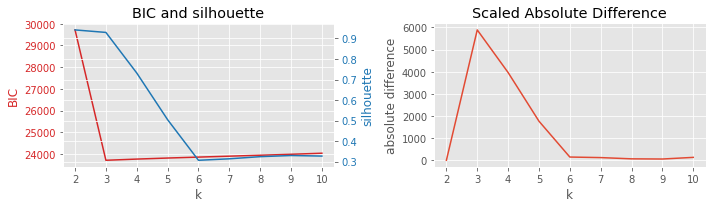

In [5]:
plot_result(df, 'BIC', 'silhouette', 'k')

### BIC vs Davies-Bouldin

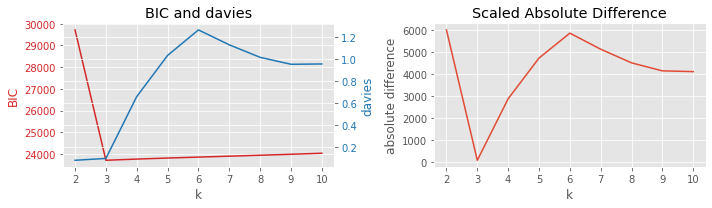

In [6]:
plot_result(df, 'BIC', 'davies', 'k')

### BIC vs homogeneity

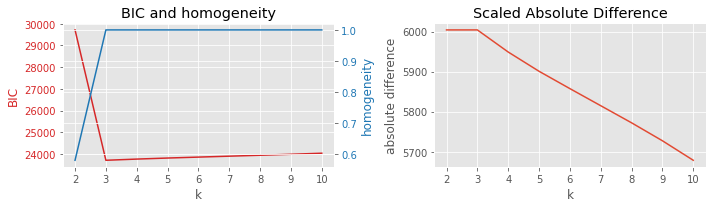

In [7]:
plot_result(df, 'BIC', 'homogeneity', 'k')

### BIC vs completeness

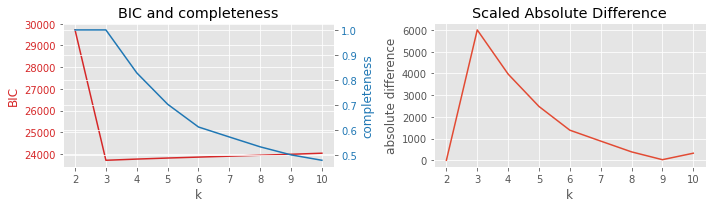

In [8]:
plot_result(df, 'BIC', 'completeness', 'k')

### BIC vs Calinski-Harabasz

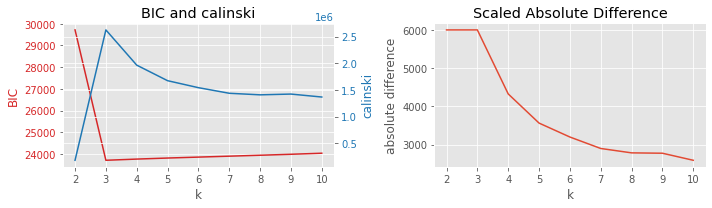

In [9]:
plot_result(df, 'BIC', 'calinski', 'k')

### BIC vs v-measure

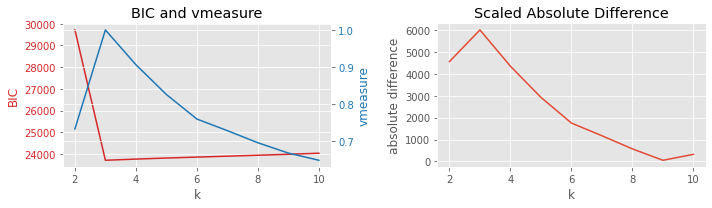

In [10]:
plot_result(df, 'BIC', 'vmeasure', 'k')